## Prepare data

In [ ]:
# we import some libraries that will be used during the project
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

# Import matplotlib functionality 
from matplotlib import gridspec, patches
from matplotlib.colors import ListedColormap

In [ ]:
# number of dataset images 
n_imgs = 10000

# images side dimension
side_dim = 64 

# objects min/max side dimensions
obj_min_dim = 5
obj_max_dim = 15

# number of objects
n_bb = 3

# a dictionary with our classes
classes = { 0: '--',
            1: '+r',
            2: '+g',
            3: '+b',
            4: '#r',
            5: '#g',
            6: '#b',
            7: 'or',
            8: 'og',
            9: 'ob'}
            
# grey level of the background RGB = (bckg,bckg,bckg)
bckg = 200

# obj RGB colors thresholds
min_color = 1
max_color = 255

# Formula to establish image color level confidance: 
# Pc = min(1, round(max(0, abs(shape_bckg-bckg)-8) ** (5/9))/10 )
# confidence threshold
Pc_th = .4

In [ ]:
# method to create objects in images and relative bounding boxes
def new_dataset(n_imgs, 
                n_bb, 
                side_dim, 
                obj_min_dim, 
                obj_max_dim, 
                min_color, 
                max_color, 
                bckg, 
                Pc_th):
    '''
    Creation of objects in images and relative bounding boxes

    Arguments:
    n_imgs -- scalar, number of images
    n_bb -- scalar, number of Bounding Boxes
    side_dim -- size of image sides
    obj_min_dim -- scalar, minimum object size
    obj_max_dim -- scalar, maximum object size
    min_color - scalar, minimum color threshold
    max_color - scalar, maximum color threshold
    bckg - scalar, background color

    Returns:
    imgs -- np.array(n_imgs, side_dim, side_dim), images of our dataset
    bounding_boxes -- np.array(n_imgs, n_bb, 6), bounding boxes for each image
    distance -- np.array(n_imgs, n_bb), distance from origin for each Bounding box
    '''
    # inizialization of images with a light gray color
    imgs = np.ones((n_imgs, side_dim, side_dim, 3), dtype = ('uint8')) * bckg

    # inizialization of bounding boxes
    bounding_boxes = np.zeros((n_imgs, n_bb, 6))

    # inizialization of origin distance array
    distance = np.zeros((n_imgs, n_bb))

    # objects creation and evaluation of distance from origin
    for img_number in range(n_imgs):
        for i_ogg in range(n_bb):
            # shapes:  0 = '+'  /  1 = 'x'  /  2 = '#'
            shape = np.random.randint(3) * 3

            w = np.random.randint(obj_min_dim, obj_max_dim)
            if w % 2 == 0: # we want odd numbers
                w += 1
            h = np.random.randint(obj_min_dim, obj_max_dim)
            if h % 2 == 0: # we want odd numbers
                h += 1

            x = np.random.randint(0, side_dim - w)
            y = np.random.randint(0, side_dim - h)

            R = (np.random.randint(min_color, max_color))
            G = (np.random.randint(min_color, max_color))
            B = (np.random.randint(min_color, max_color))

            shape_bckg = round(R+B+G)/3
            # initialize background shape color
            dominant_color = [shape_bckg] * 3

            # dominant color
            if R >= G and R >= B:
                dominant_color[0] = R
                cl = shape + 1
            elif G >= R and G >= B:
                dominant_color[1] = G
                cl = shape + 2
            else:
                dominant_color[2] = B
                cl = shape + 3

            # we avoid creating objects with no dominant color (tolerance 32)
            if max(R, G, B) - shape_bckg < 32:
                # no dominant color objects have no dimensions,
                # no bounding boxes and max distance from axes
                Pc = 0.  # for the moment we use for all target value Pc = 1
                bounding_boxes[img_number, i_ogg] = [0, Pc, 0, 0, 0, 0]
                distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

            # we avoid creating objects that overlap with others
            elif np.mean(imgs[img_number, y:y + h, x:x + w, :]) != bckg:
                # overlapping objects have no dimensions,
                # no bounding boxes and max distance from axes
                Pc = 0.  # for the moment we use for all target value Pc = 1
                bounding_boxes[img_number, i_ogg] = [0, Pc, 0, 0, 0, 0]
                distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

            else:
                imgs[img_number, y:y + h, x:x + w, :] = shape_bckg

                # we create a +
                if shape == 0:
                    imgs[img_number, y + h//2, x:x + w, :] = dominant_color
                    imgs[img_number, y: y + h, x + w//2, :] = dominant_color

                # we create a #
                elif shape == 3:
                    x_1 = x + (w // 3)
                    x_2 = x + ((w*2)// 3)
                    y_1 = y + (h // 3)
                    y_2 = y + ((h*2)// 3)
                    imgs[img_number, y_1, x:x + w] = dominant_color
                    imgs[img_number, y_2, x:x + w] = dominant_color
                    imgs[img_number, y:y+ h, x_1] = dominant_color
                    imgs[img_number, y:y+ h, x_2] = dominant_color

                # we create a o
                else:
                    x_from = x + (w // 3)
                    x_to = x + round(w / 3 * 2)
                    y_from = y + (h // 3)
                    y_to = y + round(h / 3 * 2)
                    imgs[img_number, y_from, x_from:x_to] = dominant_color
                    imgs[img_number, y_from:y_to, x_to] = dominant_color
                    imgs[img_number, y_from:y_to, x_from] = dominant_color
                    imgs[img_number, y_to, x_from:x_to+1] = dominant_color

                # we establish the degree of confidence of the object on the basis of
                # how dark it is in terms of black and white (sum of the RGB channels)
                Pc = min(1, round(max(0, abs(shape_bckg-bckg)-8) ** (5/9))/10 )

                # we avoid to create bounding boxes for examples under Pc_th
                if Pc < Pc_th:
                  bounding_boxes[img_number, i_ogg] = [0, 0.1, 0, 0, 0, 0]
                  distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

                else: 
                  # we generate relative bounding boxes
                  bounding_boxes[img_number, i_ogg] = [cl, 1, x, y, w, h]

                  # and calculate the distance from the origin for each Bounding Box
                  distance[img_number, i_ogg] = np.sqrt(np.square(x + (w / 2)) + np.square(y + (h / 2)))
                  if (x + (w / 2)) < (y + (h / 2)):
                    # to give an extra order element we differenciate object 
                    # above and below the diagonal y = x
                    distance[img_number, i_ogg] = -distance[img_number, i_ogg]


    return imgs, bounding_boxes, distance

In [ ]:
# creation of images, Bounding Boxes and an origin distance to order BB
imgs, bounding_boxes, distance = new_dataset( n_imgs, 
                                              n_bb, 
                                              side_dim, 
                                              obj_min_dim, 
                                              obj_max_dim, 
                                              min_color, 
                                              max_color,
                                              bckg,
                                              Pc_th)

In [ ]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (10000, 64, 64, 3)
Dimension of BBoxes array: (10000, 3, 6)
Dimension of distance array: (10000, 3)


In [ ]:
# objects created above and below our Pc_th
above_pc_obj = np.count_nonzero(bounding_boxes[:,:,1] == 1)
below_pc_obj = np.count_nonzero(bounding_boxes[:,:,1] == .1)
no_obj = (n_imgs * n_bb) - (above_pc_obj + below_pc_obj)
print('Obj above Pc_th:', above_pc_obj)
print('Obj below Pc_th:', below_pc_obj)
print('Obj not created:', no_obj)

Obj above Pc_th: 21180
Obj below Pc_th: 1632
Obj not created: 7188


In [ ]:
# bounding boxes sorting based on distance from the origin
def order_bb(bounding_boxes, distance):   
    '''
    Arguments:
    bounding_boxes -- np.array(N_imgs, N_bb, 6), bounding boxes for each image
    distance -- np.array(N_imgs, N_bb), distance from origin for each Bounding box
    Returns:
    bboxes -- np.array(N_imgs, N_bb, 5), bounding boxes ordered
    '''

    n_imgs = bounding_boxes.shape[0]
    n_bb = bounding_boxes.shape[1]

    order = np.zeros((n_imgs, n_bb), dtype=int)
    bboxes = np.zeros(bounding_boxes.shape)

    for i in range(n_imgs):
        order[i] = np.argsort(distance[i])
        for j in range(n_bb):
            bboxes[i, j] = (bounding_boxes[i, order[i, j]])

    return bboxes

In [ ]:
bb_ordered = order_bb(bounding_boxes, distance) 

In [ ]:
# we compute images mean and image standar deviation
imgs_mean = np.mean(imgs)
imgs_std = np.std(imgs)

In [ ]:
# We normalize our images 
X = imgs - imgs_mean  # centering
X /= imgs_std         # scaling
print('X shape: ', X.shape, '---- Average value: ', imgs_mean, '---- Standard deviation:', np.std(imgs))

X shape:  (10000, 64, 64, 3) ---- Average value:  196.24932248535157 ---- Standard deviation: 18.443564941105414


In [ ]:
# we reshape target value
Y = bb_ordered.reshape(n_imgs, -1) 
print('Y shape: ',Y.shape)

Y shape:  (10000, 18)


In [ ]:
# split data into training, validation, and test sets (70%, 15%, 15%)

i_val = int(0.7 * n_imgs)
i_test = int(0.85 * n_imgs)

X_train = X[:i_val]
Y_train = Y[:i_val]

X_val = X[i_val:i_test]
Y_val = Y[i_val:i_test]

X_test = X[i_test:]
Y_test = Y[i_test:]

print('Below the dimensions of X and Y for Training set and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set and Test set respectively

(7000, 64, 64, 3) (7000, 18) (1500, 64, 64, 3) (1500, 18)


## Train the model


## Setup Keras

In [ ]:
# check tensorflow version
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  print(tf.__version__)
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# to garantee Python 2/3 compatible codebase
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

# check eagerly execution on
print('Eagerly execution:', tf.executing_eagerly())

Eagerly execution: True


In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
# get some basic data from our dataset
n_examples = X.shape[0]
side_dim = X.shape[1]
n_bb = Y.shape[1]//5
n_classes = 10

# insert in a 'coords' the coordinates of the bounding boxes for each example
coords = []
for i in range(0,n_bb*6,6):
  for j in range(2,6):
    coords.append(i+j)

print('Number of examples:', n_examples)
print('Number of classes:', n_classes-1)
print('Image dimension:', side_dim, 'x', side_dim)
print('Number of bounding boxes:', n_bb, '\n')

print('...and also some statistical data')
print('Images mean:', imgs_mean)
print('Images standard deviation:', imgs_std)

Number of examples: 10000
Number of classes: 9
Image dimension: 64 x 64
Number of bounding boxes: 3 

...and also some statistical data
Images mean: 196.24932248535157
Images standard deviation: 18.443564941105414


In [ ]:
# clear graph
keras.backend.clear_session()

#GPU

In [ ]:
# using GPU to train the model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12039558202525241562
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14013936515945782962
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


#Defining the model

In [ ]:
class base_model():
  def __init__(self, side_dim, n_bb, n_classes, name_model):
    self.side_dim = side_dim
    self.name_model = name_model      
    # base model DenseNet
    if name_model == 'DenseNet201':
      self.base_model = keras.applications.DenseNet201(include_top=False,
                              input_shape=(self.side_dim, self.side_dim, 3))

      self.image_input = self.base_model.input

      self.flatten = keras.layers.Flatten()(self.base_model.layers[-2].output)

      self.BatcNorm = keras.layers.BatchNormalization()(self.flatten)

      print('Base model: DenseNet201 (18.7 M params x 201 layers')


    # ----------------------------------------------------------------------
    # Add head with three different outputs to last layer of the basic model 
    # ----------------------------------------------------------------------   
    # class output 
    self.class_categorical = keras.layers.Dense((n_bb * n_classes), 
                                                activation='softmax')(self.BatcNorm)
    self.class_output = keras.layers.Reshape((n_bb, n_classes), 
                                             name='class_output')(self.class_categorical)

    # confidence output
    self.score_confidence = keras.layers.Dense((n_bb), 
                                               name='score_confidence', 
                                               activation='tanh')(self.BatcNorm)
    # bounding boxes coordinate output
    self.score_coords = keras.layers.Dense((n_bb * 4), 
                                           name='score_coords')(self.BatcNorm)


#Visualizing a really deep network

Base model: DenseNet201 (7.2M params x 201 layers
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.417223 to fit



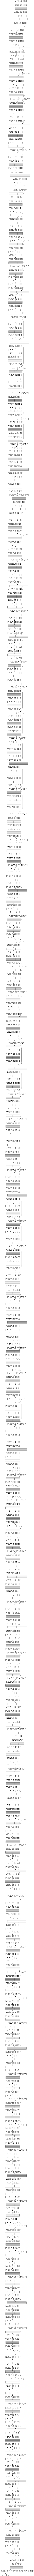

In [ ]:
# select the base model to test
base_model_name = 'DenseNet201'
base = base_model(side_dim = side_dim, 
             n_bb = n_bb, 
             n_classes = n_classes, 
             name_model = base_model_name) 

# we combine our three outputs into one head
myModel = keras.Model(inputs = base.image_input,
                        outputs = [base.class_output, 
                                   base.score_confidence, 
                                   base.score_coords],
                        name = base_model_name)
# a visual look to the model graph 
keras.utils.plot_model(myModel, 'multi_output_model.png', show_shapes=True)

In [ ]:
# trasform Y to 3 different target value
def trasform_y(Y, coords):
  class_target = Y[:,::6].reshape(Y.shape[0],n_bb,-1)
  class_target = tf.keras.utils.to_categorical(class_target, dtype='float32')
  target_confidence = Y[:,1::6].astype('float32')  
  target_coords = Y[:,coords].astype('float32')

  out = [class_target, target_confidence, target_coords]
  return out

In [ ]:
# target for training data
class_target, target_confidence, target_coords = trasform_y(Y_train, coords)

# target for validation data  
Val_class, Val_confidence, Val_coords = trasform_y(Y_val, coords)

print('Target value dimensions for training set (class, confidance, coordinates)')
print(class_target.shape, target_confidence.shape, target_coords.shape, '\n')
print('Target value dimensions for Validation set (class, confidance, coordinates)')
print(Val_class.shape, Val_confidence.shape, Val_coords.shape)

Target value dimensions for training set (class, confidance, coordinates)
(7000, 3, 10) (7000, 3) (7000, 12) 

Target value dimensions for Validation set (class, confidance, coordinates)
(1500, 3, 10) (1500, 3) (1500, 12)


In [ ]:
# models names
model_name = base_model_name + str(n_examples//1000) + '_10k_3bb'

In [ ]:
# runing tensorboard for monitoring the training process
from datetime import datetime
import pytz
EST = pytz.timezone('US/Eastern')
# logdir to use tensorboard 
logdir = "./" +  model_name + '_' + datetime.now().astimezone(EST).strftime("%Y%m%d")
tf.summary.create_file_writer(logdir=logdir)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [ ]:
# coordinates loss function 
def rmse(y_true, y_pred):
  '''  
  Arguments:
  y_true -- tensor with expected Y
  y_pred -- tensor with predicted Y
  
  Returns:
  euc_dist -- scalar
  '''
  rmse = keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1))
  return rmse

#Defining optimization and loss

In [ ]:
# model configuration for training
myModel.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001, 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-07, 
                                      amsgrad=False,
                                      name='Adam'),

    loss = {'class_output': keras.losses.CategoricalCrossentropy(),
            'score_confidence': keras.losses.CategoricalHinge(), #MeanSquaredError(), #AbsoluteSquaredError
            'score_coords': rmse }, # keras.losses.MeanSquaredError
          
    metrics = {'class_output': ['accuracy'],
               'score_confidence': ['accuracy'],
               'score_coords': ['accuracy']},
            
    loss_weights = {'class_output': 2, 'score_confidence': 1, 'score_coords': 4})

In [ ]:
# set callback to stop training if validation loss doesn't improve
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1)]

In [ ]:
# numbers of epochs and mini-batch size
N_ep = 100
init_ep = 15
Batchs = 64

In [ ]:
from tensorflow.python.client import device_lib

In [ ]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3618336724828403970
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7052530013840275421
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


#Traning process

In [ ]:
# start our training
train_history = myModel.fit({myModel.input.name: X_train}, 
                    {'class_output': class_target, 
                     'score_confidence': target_confidence, 
                     'score_coords': target_coords},
                    epochs=N_ep, 
                    validation_data=({myModel.input.name: X_val}, 
                                     {'class_output': Val_class, 
                                      'score_confidence': Val_confidence, 
                                      'score_coords': Val_coords}), 
                    batch_size=Batchs, 
                    initial_epoch = init_ep, 
                    verbose=1,
                    callbacks=[callbacks, 
                               tensorboard_callback])

Epoch 16/100
110/110 [==============================] - 51s 278ms/step - loss: 39.6851 - class_output_loss: 1.5691 - score_confidence_loss: 0.1574 - score_coords_loss: 9.0974 - class_output_accuracy: 0.5127 - score_confidence_accuracy: 0.5373 - score_coords_accuracy: 0.6853 - val_loss: 42.2028 - val_class_output_loss: 3.0087 - val_score_confidence_loss: 0.2170 - val_score_coords_loss: 8.9921 - val_class_output_accuracy: 0.4162 - val_score_confidence_accuracy: 0.6173 - val_score_coords_accuracy: 0.6453
Epoch 17/100
110/110 [==============================] - 22s 197ms/step - loss: 16.1106 - class_output_loss: 0.9715 - score_confidence_loss: 0.0541 - score_coords_loss: 3.5284 - class_output_accuracy: 0.6638 - score_confidence_accuracy: 0.4690 - score_coords_accuracy: 0.8164 - val_loss: 21.8128 - val_class_output_loss: 1.1088 - val_score_confidence_loss: 0.0813 - val_score_coords_loss: 4.8785 - val_class_output_accuracy: 0.6576 - val_score_confidence_accuracy: 0.4893 - val_score_coords_acc

# Saving results
Once we have reached a satisfactory level of learning (we try to get the most out of each of our models) we save our neural network.

In [ ]:
# general adn model path 
model_path = './models/'

In [ ]:
# model path and filename 
model_to_save = model_path + model_name + '_' + str(N_ep) + '_ep.h5'
# model saving
myModel.save(model_to_save)

In [ ]:
# coordinates loss function
def rmse(y_true, y_pred):
  '''  
  Arguments:
  y_true -- tensor with expected Y
  y_pred -- tensor with predicted Y
  
  Returns:
  euc_dist -- scalar
  '''
  rmse = K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))
  return rmse

In [ ]:
def select_model(model_name):

  if model_name == 'AlexNet':
    model_filename = '/content/models/AlexNet10_10k_3bb_100_ep.h5'
  elif model_name == 'DensNet':
    model_filename = '/content/models/DenseNet20110_10k_3bb_100_ep.h5'
  print('Selected model', model_name)
  # load model
  model = keras.models.load_model(model_filename, custom_objects={'rmse': rmse})

  return model

In [ ]:
# model path with models names
model_path = 'models/'
model_name = 'DensNet'

In [ ]:
# clear ghraph
tf.keras.backend.clear_session()

# model selection
model = select_model(model_name)

Selected model DensNet


In [ ]:
# the structure of the model
model.summary()

Model: "DenseNet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']   

#Test process

In [ ]:
# Predictions from neural network using Test set as input
model_predictions = model.predict(X_test)

47/47 [==============================] - 6s 24ms/step


In [ ]:
# Useful informations about data images 
n_examples = X_test.shape[0]    # number of examples in Test-set
side_dim = X_test.shape[1]      # side dimension for each image
n_bb = Y_test.shape[1] // 6     # bounding boxes for each image

print('Test examples:', X_test.shape[0])
print('Image size:', side_dim, 'x', side_dim)
print('Bounding boxes per image:', n_bb)
print('-------')
print('Images mean:', imgs_mean)
print('Images standard deviation:', imgs_std)

Test examples: 1500
Image size: 64 x 64
Bounding boxes per image: 3
-------
Images mean: 196.24932248535157
Images standard deviation: 18.443564941105414


In [ ]:
# decompose predictions by different targets (class, confidence, coordinates)
predict_class = model_predictions[0].reshape(n_examples, n_bb, -1)
predict_confidence = model_predictions[1].reshape(n_examples, -1, 1) / 2 + (1/2) # *Remember: we use tanh as activation function 
predict_bboxes = model_predictions[2].reshape(n_examples, n_bb, -1)

# True and Predict value for level of confidence
true_confidence = Y_test[:, 1::6].reshape(-1)
pred_confidence = predict_confidence.reshape(-1)

# reshape and convert softmax data to class prediction  
predict_class = predict_class.argmax(-1).reshape(n_examples, n_bb, 1)

true_class = Y_test[:, 0::6].reshape(-1).astype('int8')
pred_class = predict_class.reshape(-1).astype('int8') 

- bounding boxes 
- confusion metrix

## The IoU

In [ ]:
def IoU(box1, box2):
  '''  
  Arguments:
  box1 -- first box, with coordinates (x, y, w, h)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x, y, w, h] = box1
  [x2, y2, w2, h2] = box2
  # Intesection area 
  xi1 = np.maximum(x, x2)
  yi1 = np.maximum(y, y2)
  xi2 = np.minimum(x+w, x2+w2)
  yi2 = np.minimum(y+h, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w*h)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/max(union_area, 1e-9)
  return iou

In [ ]:
# The average IoU of the whole dataset
def mean_IoU(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, n_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, n_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  iou_global = 0
  real_bb = 0
  for i in range(total_bb):
    [eCl, _, x , y, w, h] = expe[i, :] 
    [cl, _, x2, y2, w2, h2] = pred[i, :]  
    if cl == 0:
      pass
    else: 
      iou_global += IoU([x,y,w,h], [x2,y2,w2,h2])
      real_bb += 1

  iou_global /= real_bb
  return iou_global

In [ ]:
# The average center of the object in bounding box accuracy of the whole dataset 
def accuracy_centre(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, N_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, N_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  acc_global = 0
  real_bb = 0
  for i in range(total_bb):
    [cl, _, x , y, w, h] = expe[i, :] 
    [eCl, _, x2, y2, w2, h2] = pred[i, :]  
    if eCl == 0:
      pass
    else: 
      centreX = x+(w/2)
      centreY = y+(h/2)
      real_bb += 1
      acc_global += (x2 < centreX < x2+w2) and (y2 < centreY < y2+h2)

  acc_global /= real_bb

  return acc_global

In [ ]:
# The average center of the object in bounding box accuracy of the whole dataset 
def accuracy_centre(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, N_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, N_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  acc_global = 0
  real_bb = 0
  for i in range(total_bb):
    [cl, _, x , y, w, h] = expe[i, :] 
    [eCl, _, x2, y2, w2, h2] = pred[i, :]  
    if eCl == 0:
      pass
    else: 
      centreX = x+(w/2)
      centreY = y+(h/2)
      real_bb += 1
      acc_global += (x2 < centreX < x2+w2) and (y2 < centreY < y2+h2)

  acc_global /= real_bb

  return acc_global

In [ ]:
# concatenate reshaped predictions to use during visualization
pred_bboxes = np.concatenate((predict_class, predict_confidence, predict_bboxes), 2)

# reshaped expected bboxes of our Validation set
expe_bboxes = Y_test.reshape(n_examples, n_bb, -1)

# check equivalence of their dimension
pred_bboxes.shape, expe_bboxes.shape

((1500, 3, 6), (1500, 3, 6))

In [ ]:
# mean IoU and accuracy center of all Test set 
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
m_acc = accuracy_centre(expe_bboxes, pred_bboxes)

# MyAlexNet (48.2M params x 8 layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.5518407050611669
Test-set mean xy-center Acc: 0.9050613014775228 



In [ ]:
def visualize_predictions(n_visual, rand_examples, iou_tr, imgTest, pred_bboxes, expe_bboxes):
    '''
    Arguments:
    ax -- plot image
    img -- np.array(side_dim,side_dim,3), an image
    bboxes -- np.array(n_bb,6), predicted bounding boxes
    expe_bboxes -- np.array(n_bb,6), expected bounding boxes
    iou_tr -- scalar, IoU treshold

    Returns:
    None
    '''
    # image side dimension
    side_dim = imgTest.shape[1]

    # number of bounding boxes
    n_bb = pred_bboxes.shape[1]

    # show predictions
    fig = plt.figure(figsize=(18,8))
    for i in range (n_visual):
      
      # We take a random image of our training set
      im = rand_examples[i]
      ax = fig.add_subplot((n_visual//4)+1,4, i+1)
      ax.grid( which='both', color='w', linestyle=':')
      plt.xticks(np.arange(0, side_dim, step=10))
      ax.set_title('Imagine n.' + str(im))

      img = imgTest[im]
      pred = pred_bboxes[im]
      expe = expe_bboxes[im]

      # We look at the objects contained in it...
      ax.imshow(img, origin='upper', extent=[0, side_dim, side_dim, 0])

      # ...and the bounding boxes predicted by the algorithm
      print(' _______________________________________________________________ ')
      print('| Image:{0:6d}                   |       expected/predicted     |'.format(im))
      for j in range(n_bb):
          [Cl, Pc, x, y, w, h] = pred[j]
          Cl = classes[int(round(Cl))]
          Pc = int(round(Pc))
          

          [eCl, ePc, x2, y2, w2, h2] = expe[j, :]
          eCl = classes[int(round(eCl))]
          ePc = int(round(ePc))
          iou_bb = IoU([x, y, w, h], [x2, y2, w2, h2])
          
          if Pc == 0:
            rect = patches.Rectangle((x, y), w, h, ec='tab:blue', lw='1.4', fc='none')
          else:
            if iou_bb >= iou_tr:
                rect = patches.Rectangle((x, y), w, h, ec='tab:red', lw='1.4', fc='none')
                dida = 'IoU: ' + '{:0.3f} '.format(iou_bb)
                plt.annotate(dida + Cl, (x + w, y + 0.8), color='tab:red')

            else:
                rect = patches.Rectangle((x, y), w, h, ec='tab:green', lw='1.4', fc='none')

          ax.add_patch(rect)
          print('| Object bounding Box IoU: {0:5.1%} | confidence {1:1d}/{2:1d} | class {3}/{4} |'.format(iou_bb, ePc, Pc, eCl, Cl))
    plt.show()

In [ ]:
# Image decoding from normalized dataset
imgTest = ((np.reshape(X_test, (n_examples, side_dim, side_dim, 3)) * imgs_std) + imgs_mean)/255

# Internent over Union treshold to consider valid Bounding Boxes
iou_tr = .3

# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 3

# take n_visual random examples
rand_examples = np.random.randint(n_examples, size = (n_visual,))

# examples for the model  
rand_examples = [0, 10, 105]

 _______________________________________________________________ 
| Image:     0                   |       expected/predicted     |
| Object bounding Box IoU: 75.0% | confidence 1/1 | class #b/#b |
| Object bounding Box IoU: 42.1% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _______________________________________________________________ 
| Image:    10                   |       expected/predicted     |
| Object bounding Box IoU: 77.2% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 50.3% | confidence 1/1 | class +r/+r |
| Object bounding Box IoU:  0.0% | confidence 0/1 | class --/-- |
 _______________________________________________________________ 
| Image:   105                   |       expected/predicted     |
| Object bounding Box IoU: 64.5% | confidence 1/1 | class +g/+g |
| Object bounding Box IoU: 55.3% | confidence 1/1 | class #r/#r |
| Object bounding Box IoU: 49.8% | confidence 1/1 | class #r/#r |


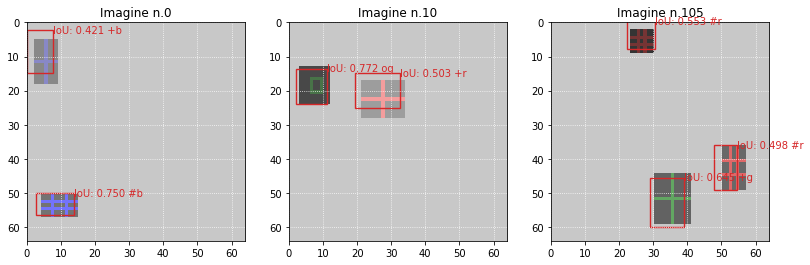

In [ ]:
# Random Model (random predictions - no params x no layers)
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

## Classification

In [ ]:
# Precision, Recall, F1_score
c_report = classification_report(true_class, pred_class, target_names=list(classes.values()))
class_confusion_matrix = confusion_matrix(true_class, pred_class)

In [ ]:
def plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix):
  cl = classes.values()
  ticks = np.arange(0,10)

  fig = plt.figure(figsize=(14,6))
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=5, nrows=5, width_ratios=[1.1,.2,1.8,.3,.9]) 
  # ax1 = fig.add_subplot(gs[1:4,0])
  ax2 = fig.add_subplot(gs[:,2])
  ax3 = fig.add_subplot(gs[:,4])

  # Plot Histogram obj classes distribution
  bins = np.arange(0, 11, 1)
  # ax1.hist([true_class, pred_class], bins=bins-0.5, color=('y','g'))
  # ax1.set(title='obj real classes / predictions', xlabel='classes', ylabel='num examples')
  # ax1.set_xticks(ticks=bins) 
  # ax1.set_xticklabels(cl)
  # ax1.legend(['Real class','Predicted class'])

  # confusion matrix
  ax2.set_title('Confusion matrix')

  cmap = 'cividis'
  ax2.imshow(class_confusion_matrix, cmap=cmap)
  ax2.set_xlabel('predicted classes')
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(cl)
  ax2.set_ylabel('true classes')
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(cl)
  for i in range(class_confusion_matrix.shape[0]):
    for j in range(class_confusion_matrix.shape[1]):
      ax2.text(j, i ,class_confusion_matrix[i,j], color=[.8,.4,.1], fontsize=10, horizontalalignment='center',)

  ax3.axis('off')
  ax3.text(0.5, .5, c_report, wrap=True, horizontalalignment='center', verticalalignment='center', fontsize=12)
  plt.show()

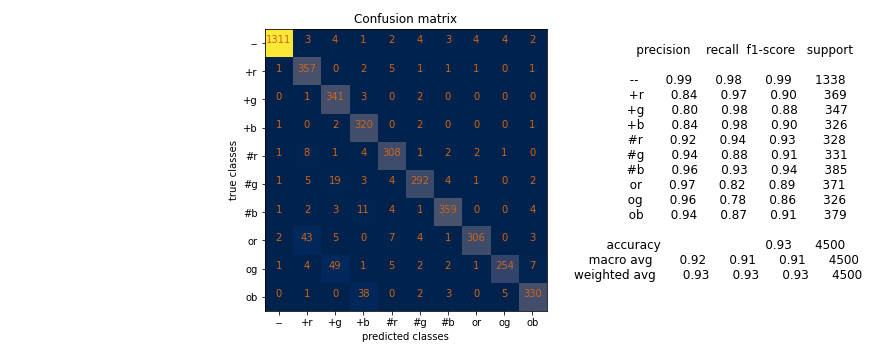

In [ ]:
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)